# House Prices

This guide runs through building, training and evaluation of models for estimating house prices in California. The models in this example are using quad pooling operations. In the guide we will be using [California Housing](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html) dataset. The dataset is comprised of 20640 data points with 8 features each, including geographical coordinates.

In [1]:
!pip install matplotlib osmnx geopandas torchmetrics scikit-learn -qqq

## Defining the Dataset

In order to use the data for training a neural network, we need to define a dataset class, that should inherit from the standard [torch.utils.data.Dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset), and implement `__len__` and `__getitem__`.

Since the dataset is relatively small, we could simply download it into memory and then parse CSV file to turn it into the Pandas `DataFrame`.

In [2]:
import pandas as pd
from sklearn.datasets import fetch_california_housing


dataset = fetch_california_housing(as_frame=True).frame
dataset.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


Below you can see sample of dataset, or coordinates of houses in California depicted as blue dots. Black lines in the picture represent coastlines from the [Open Street Map](https://openstreetmap.org).

In [3]:
import warnings
warnings.simplefilter("ignore")

import osmnx as ox


lon_min = dataset["Longitude"].min()
lon_max = dataset["Longitude"].max()
lat_min = dataset["Latitude"].min()
lat_max = dataset["Latitude"].max()

bounding_box = (lat_max, lat_min, lon_max, lon_min)
coastlines = ox.features_from_bbox(bbox=bounding_box, tags={"natural": "coastline"})

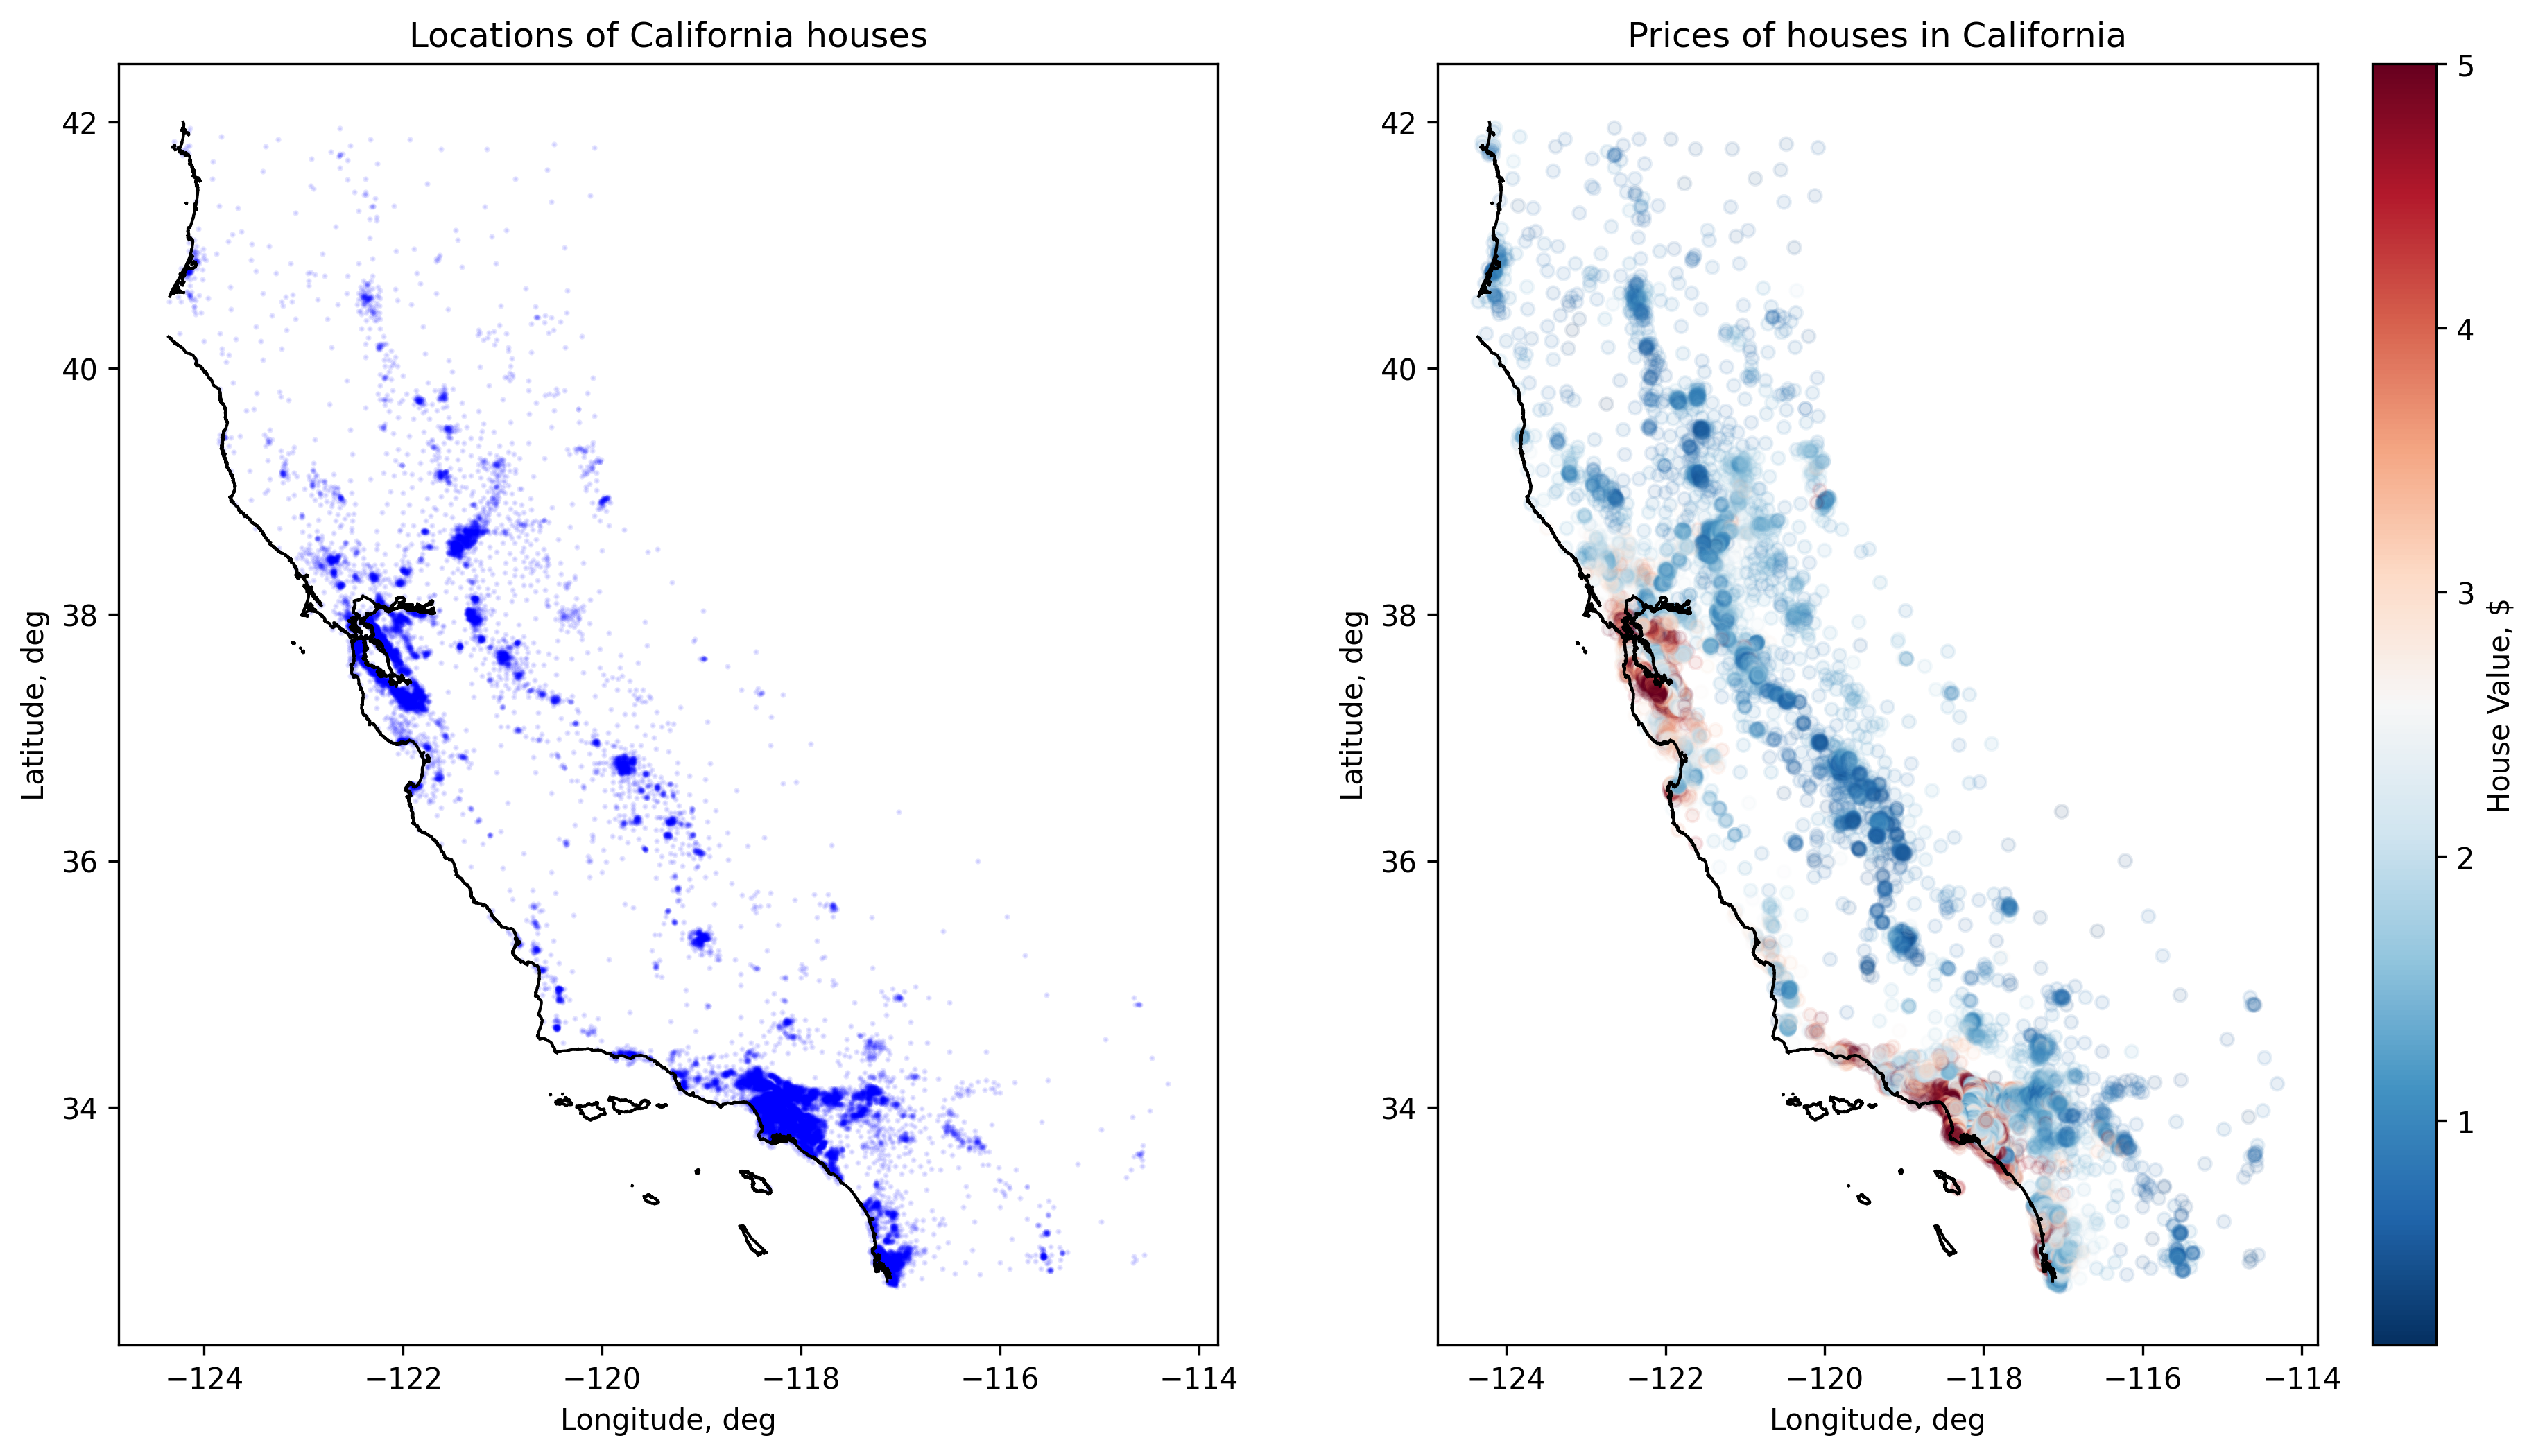

In [4]:
from matplotlib import pyplot as plot
from matplotlib import colors
from matplotlib import cm
from shapely import Polygon, LineString


def render_coastlines(ax):
    for coastline in coastlines.itertuples():
        if isinstance(coastline.geometry, Polygon):
            ax.plot(*coastline.geometry.exterior.xy, color="black", lw=1)
        if isinstance(coastline.geometry, LineString):
            ax.plot(*coastline.geometry.xy, color="black", lw=1)

fig, ax = plot.subplots(ncols=2)
fig.set_dpi(300)
fig.set_size_inches(15, 8)


cmap = plot.get_cmap("RdBu_r")
norm = colors.Normalize(
    vmin=dataset["MedHouseVal"].min(),
    vmax=dataset["MedHouseVal"].max(),
)

ax[0].set_xlabel("Longitude, deg")
ax[0].set_ylabel("Latitude, deg")
ax[0].scatter(dataset["Longitude"], dataset["Latitude"], s=1, color="blue", alpha=0.1)
ax[0].set_title("Locations of California houses")

ax[1].set_xlabel("Longitude, deg")
ax[1].set_ylabel("Latitude, deg")
ax[1].scatter(
    dataset["Longitude"], dataset["Latitude"],
    s=20, color=cmap(norm(dataset["MedHouseVal"])),
    alpha=0.1
)
ax[1].set_title("Prices of houses in California")

fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax[1], label="House Value, $")

render_coastlines(ax[0])
render_coastlines(ax[1])

On the next step we need to split dataset into training and test sub-sets, in this example we will use 80% of data for training and 20% of data for testing (evaluation) of a model.

In [5]:
import numpy as np
import torch
from torch.utils.data import Dataset, random_split


class HousePricesDataset(Dataset):
    def __init__(self, df):
        self.df = df
        self.max_value = df["MedHouseVal"].max()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Take necessary row from the dataset and convert it to torch.Tensor.
        x = self.df.iloc[idx][["Longitude", "Latitude"]].to_numpy(dtype=np.float64)
        y = self.df.iloc[idx][["MedHouseVal"]].to_numpy(dtype=np.float64)# / self.max_value
        return torch.DoubleTensor(x), torch.DoubleTensor(y)


train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size

houses_prices_dataset = HousePricesDataset(dataset)
train_set, test_set = random_split(houses_prices_dataset, [train_size, test_size])

## Defining Models

The model we are going to use will be compare regular quad pooling layer and adaptive quad pooling layer. Essentially, those modules build [quadtree](https://en.wikipedia.org/wiki/Quadtree) for spatial decomposition of the points. We assume that houses within similar geographical coordinates cost similar money.

Adaptive module allows to dynamically shape the decomposition based on density of points: regions with higher density are finer grained than regions with fewer points. Regular pooling module on the other hand, tiles the target polygon into quads of the same size.

Below we define two models `QuadNN` and `AdaptiveQuadNN` that use quad pooling operations: regular and adaptive.

In [6]:
from torch import nn
from torch_geopooling.nn import AdaptiveQuadPool2d
from torch_geopooling.nn import QuadPool2d


class QuadNN(nn.Module):

    def __init__(self, bbox):
        super().__init__()
        n, s, e, w = bbox
        self.pool = QuadPool2d(
            feature_dim=1,
            polygon=Polygon([(w, s), (e, s), (e, n), (w, n)]),
            exterior=(-180, -90, 360, 180),
            max_depth=10
        )
        self.linear = nn.Linear(1, 1, dtype=torch.float64)

    def forward(self, x):
        x = torch.clamp(self.pool(x), 0.0)
        x = self.linear(x)
        return x


class AdaptiveQuadNN(nn.Module):

    def __init__(self):
        super().__init__()
        self.pool = AdaptiveQuadPool2d(
            feature_dim=1,
            exterior=(-180, -90, 360, 180),
            capacity=10,
            max_depth=12
        )
        self.linear = nn.Linear(1, 1, dtype=torch.float64)

    def forward(self, x):
        x = self.pool(x)
        x = self.linear(x)
        return x

## Training Models

Further we use a standard training loop and Stochastic Gradient Descent optimization algorithm to train models. Note, that adaptive pooling operations are using sparse weight tensor and therefore only a limited set of optimization algorithms could be used for training.

In [7]:
from torch.utils.data import DataLoader
from torch.optim import SGD


def train(model, lr=0.1, epochs=10):
    loss_fn = nn.HuberLoss()
    optimizer = SGD(model.parameters(), lr=lr)

    for epoch in range(epochs):
        for batch in DataLoader(train_set, batch_size=2048):
            x, y = batch
            optimizer.zero_grad()
            y_pred = model(x)
    
            loss = loss_fn(y, y_pred)
            loss.backward()
            optimizer.step()
    return model

In [8]:
qnn = train(QuadNN(bounding_box), lr=1.0, epochs=50)

In [9]:
aqnn = train(AdaptiveQuadNN(), lr=1.0, epochs=50)

## Evaluating Models

On the final step, we evaluate models' performance and compute mean absolute error and weighted mean absolute percentage error. As you could see the from the table below, both models require improvements.

Additionally, `torch_geopooling` library provides `TileWKT` transformer that allows to inspect the model and plot quads that where learned by the model. Below are presented learned decomposition for regular and adaptive pooling operations.

In [10]:
import warnings
warnings.filterwarnings("ignore")

from torchmetrics import MeanAbsoluteError
from torchmetrics import WeightedMeanAbsolutePercentageError


def test(model):
    mae = MeanAbsoluteError()
    wmape = WeightedMeanAbsolutePercentageError()

    test_loader = DataLoader(train_set, batch_size=len(test_set))
    x, y_true = next(iter(test_loader))
    y_pred = model.eval()(x)

    return {
        "MAE": mae(y_true, y_pred).numpy(),
        "wMAPE": wmape(y_true, y_pred).numpy(),
    }

metrics = {}
with torch.no_grad():
    metrics["QuadNN"] = test(qnn)
    metrics["AdaptiveQuanNN"] = test(aqnn)

pd.DataFrame(metrics)

,QuadNN,AdaptiveQuanNN
MAE,0.62189245,0.8252109
wMAPE,0.30851611,0.5629974


Below are depicted tiles colored with learned prices, the prices are calculated for centers for the learned tiles. As it could be seen, adaptive quad pooling operation changes the resolution of tiles, when the density of data increases.

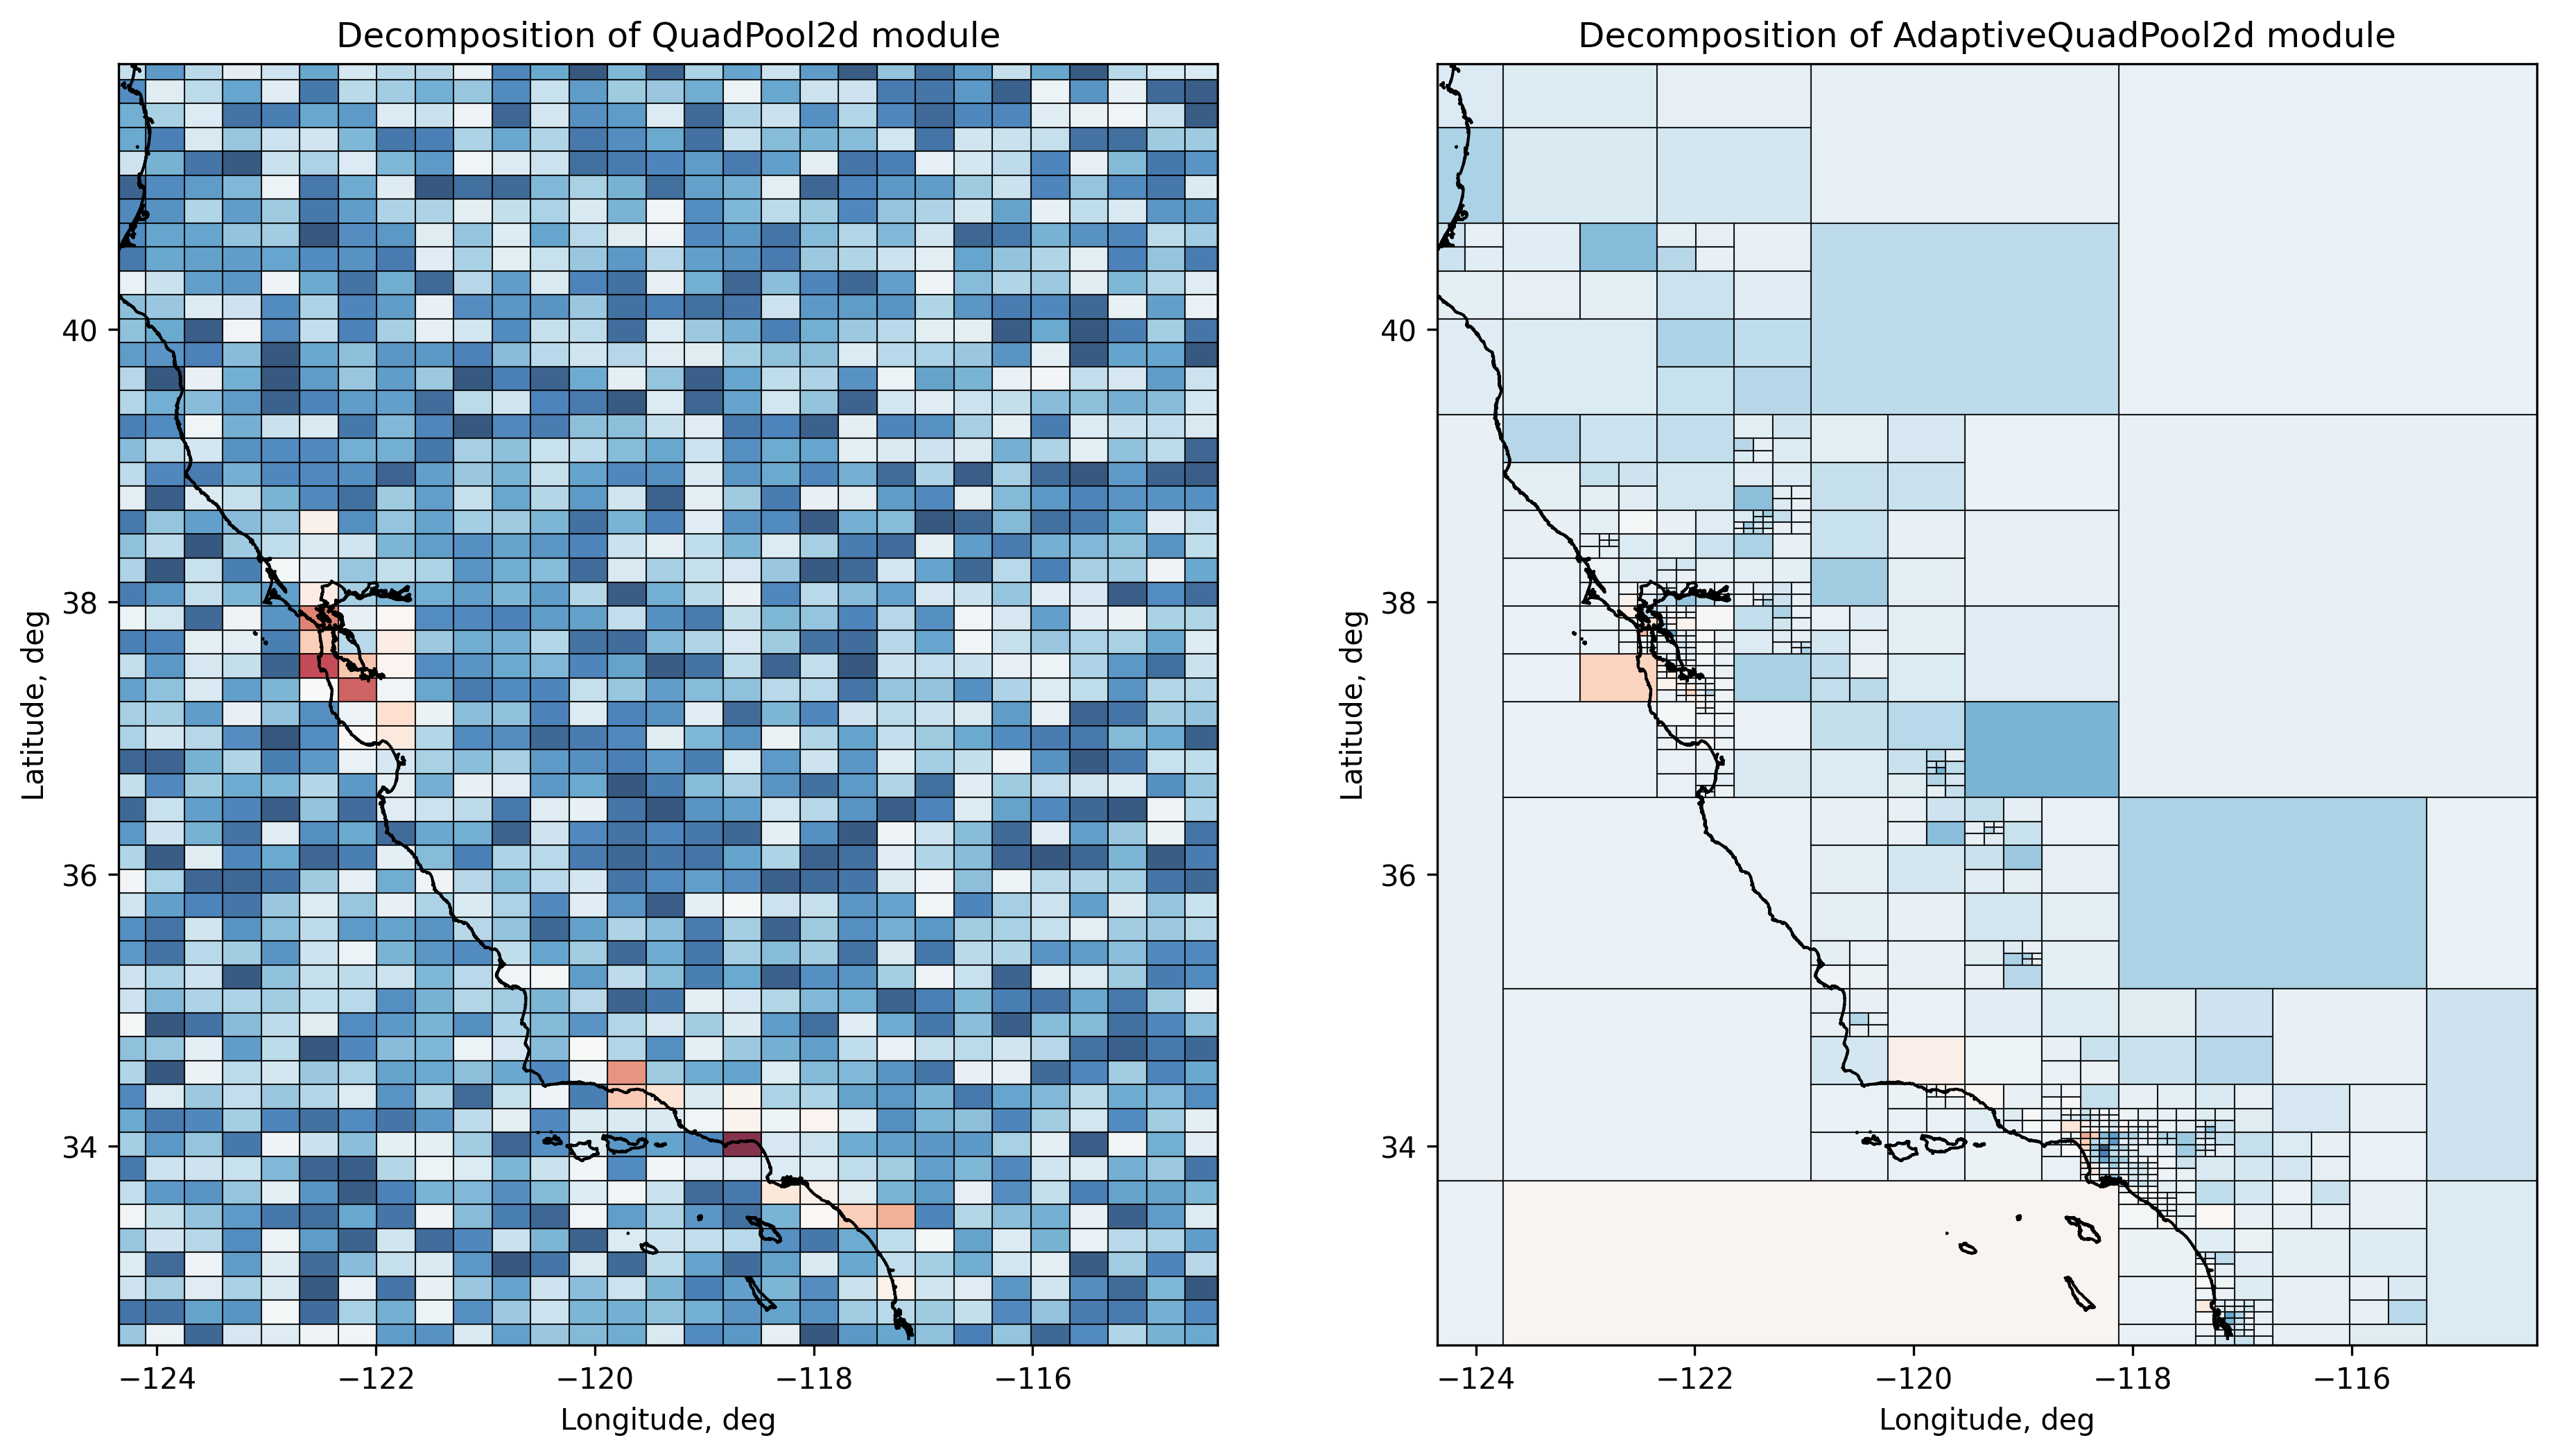

In [11]:
from torch_geopooling.transforms import TileWKT
from shapely import from_wkt


def render_tiles(ax, model, tiles, bbox):
    centers = []
    exterior = (-180, -90, 360, 180)
    transformer = TileWKT(exterior=exterior, internal=False)

    # Calculate centers of terminal nodes in a quadtree and then use these
    # coordinates to compute associated prices for each quad in the final tree.
    for tile in transformer(tiles):
        poly = from_wkt(tile)
        center = poly.representative_point()
        centers.append((center.x, center.y))

    with torch.no_grad():
        values = model(torch.DoubleTensor(centers)).detach().numpy()

    # Use different colors to represent housing prices: warm colors of the
    # spectre are associated with higher prices, while cooler colors of the
    # spectre depic lower prices.
    cmap = plot.get_cmap("RdBu_r")
    norm = colors.Normalize(vmin=np.min(values), vmax=np.max(values))

    for i, tile in enumerate(transformer(tiles)):
        poly = from_wkt(tile)
        ax.fill(*poly.exterior.xy, color=cmap(norm(values[i])), lw=0.5, edgecolor="black", alpha=0.8)

    n, s, e, w = bbox
    ax.set_xlim(w, e)
    ax.set_ylim(s, n)
    ax.set_xlabel("Longitude, deg")
    ax.set_ylabel("Latitude, deg")


fig, ax = plot.subplots(ncols=2)
fig.set_dpi(300)
fig.set_size_inches(15, 8)

ax[0].set_title("Decomposition of QuadPool2d module")
ax[1].set_title("Decomposition of AdaptiveQuadPool2d module")


render_tiles(ax[0], qnn, qnn.pool.tiles, bounding_box)
render_tiles(ax[1], aqnn, aqnn.pool.weight.coalesce().indices().t()[:,:-1], bounding_box)

render_coastlines(ax[0])
render_coastlines(ax[1])